In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoLars
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
import wrangle as w

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import random 
random.seed(10)
import re

In [2]:
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')

In [3]:
df = pd.read_csv('last_csv.csv')

In [5]:
df.shape

(410, 42)

In [ ]:
# Feature engineering, we created new columns for final df

# df['win_perc'] = round((df.win / df.games_played),2)
# df['loss_perc'] = round((df.loss / df.games_played), 2)
# df['td_per_game'] = round((df.td / df.games_played),2)
# df['sk_per_game'] = round((df.Sk / df.games_played), 2)

In [ ]:
# np.where(test_df.rookie_year.isnull(), np.nan, test_df.percent_of_cap)


In [ ]:
# set(test_df.name)

Below we shifted the percent of cap column to account for the year that the player signed the contract.  
The stats from the year the contract was signed goes toward calculating the next contract cycle.

In [ ]:

# master_df = pd.DataFrame()

# for i in set(test_df.name):
#     star = test_df[test_df.name == i]
#     star = star.sort_values(by= ['name','year'])
#     star.percent_of_cap = star.percent_of_cap.shift(-1)
#     star[['percent_of_cap']] = star[['percent_of_cap']].fillna(method='ffill')
#     master_df = pd.concat([master_df, star])

In [ ]:
# master_df[master_df.name == 'Joe Burrow']

In [ ]:
# test_df[test_df.name == 'Joe Burrow']

In [ ]:
# test_df[test_df.name == 'Andy Dalton'].percent_of_cap.shift(-1)

In [ ]:
# master_df = master_df.dropna()

In [6]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    object_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return object_cols



def get_numeric_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # get a list of the column names that are objects (from the mask)
    num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    
    return num_cols


def nulls_by_col(df):
    """
    This function will:
        - take in a dataframe
        - assign a variable to a Series of total row nulls for ea/column
        - assign a variable to find the percent of rows w/nulls
        - output a df of the two variables.
    """
    num_missing = df.isnull().sum()
    pct_miss = (num_missing / df.shape[0]) * 100
    cols_missing = pd.DataFrame({
                    'num_rows_missing': num_missing,
                    'percent_rows_missing': pct_miss
                    })
    
    return  cols_missing


def nulls_by_row(df, index_id = 'name'):
    """
    """
    num_missing = df.isnull().sum(axis=1)
    pct_miss = (num_missing / df.shape[1]) * 100
    
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': pct_miss})

    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True).reset_index()[[index_id, 'num_cols_missing', 'percent_cols_missing']]
    
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [7]:
def summarize(df):
    '''
    summarize will take in a single argument (a pandas dataframe) 
    and output to console various statistics on said dataframe, including:
    # .head()
    # .info()
    # .describe()
    # .value_counts()
    # observation of nulls in the dataframe
    # distribution of numerical attributes
    '''
    print(f"""SUMMARY REPORT
=====================================================
          
          
Dataframe head: 
{df.head(3)}
          
=====================================================
          
          
Dataframe info: """)
    df.info()

    print(f"""=====================================================
          
          
Dataframe Description: 
{df.describe().T}
          
=====================================================


nulls in dataframe by column: 
{nulls_by_col(df)}
=====================================================


nulls in dataframe by row: 
{nulls_by_row(df)}
=====================================================
    
    
DataFrame value counts: 
 """)         
    for col in (get_object_cols(df)): 
        print(f"""******** {col.upper()} - Value Counts:
{df[col].value_counts()}
    _______________________________________""")                   
        
    num_cols = len(get_numeric_cols(df))
    num_rows, num_cols_subplot = divmod(num_cols, 3)
    if num_cols_subplot > 0:
        num_rows += 1
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    
    for i, col in enumerate(get_numeric_cols(df)):
        row_idx, col_idx = divmod(i, 3)
        sns.histplot(df[col], ax=axes[row_idx, col_idx])
        axes[row_idx, col_idx].set_title(f'Histogram of {col}')
    
    plt.tight_layout()
    plt.show()

SUMMARY REPORT
          
          
Dataframe head: 
             name team  year  games_played   comp    att  comp_pct     yds  \
0  Blaine Gabbert  JAX  2011          15.0  210.0  413.0      50.8  2214.0   
1  Blaine Gabbert  JAX  2012          10.0  162.0  278.0      58.3  1662.0   
2  Blaine Gabbert   SF  2015           8.0  178.0  282.0      63.1  2031.0   

   avg_yds_per_att    td   int  pass_rating  rush_att  rush_yds  rush_avg  \
0              5.4  12.0  11.0        65.38      48.0      98.0       2.0   
1              6.0   9.0   6.0        77.35      18.0      56.0       3.1   
2              7.2  10.0   7.0        86.17      32.0     185.0       5.8   

   rush_td       full_name  year_signed  percent_of_cap          Player  Age  \
0      0.0  Blaine Gabbert         2011             1.4  Blaine Gabbert   22   
1      0.0  Blaine Gabbert         2015             1.4  Blaine Gabbert   23   
2      1.0  Blaine Gabbert         2015             0.5  Blaine Gabbert   26   

   

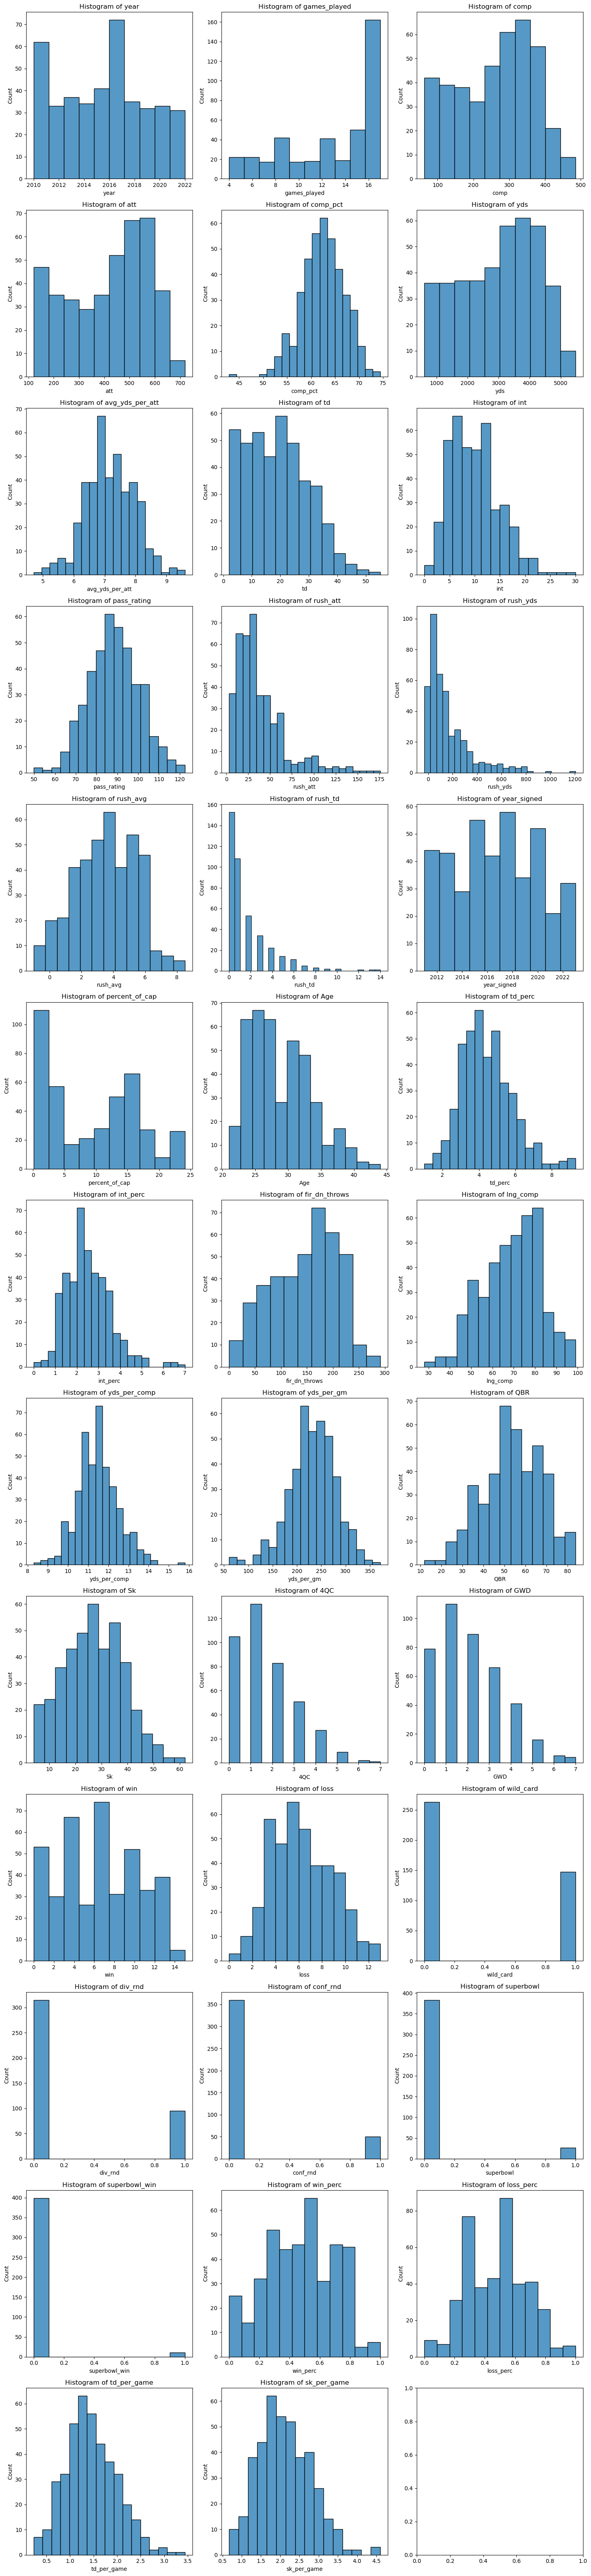

In [42]:
summarize(df)

In [8]:
# SPLIT FUNCTION

def split_function(df):
    '''
    Take in a data frame and returns:
    train, validate, test 
    subset data frames
    '''
    train, test = train_test_split(df,
                              test_size=0.20,
                              random_state=123,
                                  )
    train, validate = train_test_split(train,
                                  test_size=.25,
                                  random_state=123,
                                      )
    return train, validate, test

In [9]:
train, validate, test = split_function(df)

In [10]:
print(train.shape[0])
print(validate.shape[0])
print(test.shape[0])

246
82
82


In [11]:
def stats_relationship(train, var1, target):
    sns.regplot(data=train, x=var1, y=target, line_kws={'color':'red'})
    plt.show()
    
    alpha = 0.05

    r, p = stats.spearmanr(train[var1], train[target])
    print('r =', r)
    print('p =', p)
    
    if p < alpha:
        print(f"There is a relationship between the {target} and the {var1} of QB's")
    else:
        print(f"There is not a relationship between the {target} and the {var1} of QB's")


In [12]:
def correlation_tests(train, columns_list, target):
    '''
    Runs a correlation test on dataframe features vs target variable
    '''
    corr_df = pd.DataFrame({'feature': [],
                        'r': [],
                       'p': []})
    for i, col in enumerate(train[columns_list]):
        r, p = stats.pearsonr(train[col], train[target])
        corr_df.loc[i] = [col, abs(r), p]
    to_return = corr_df.sort_values(by='r', ascending=False)
    to_return['target'] = target
    return to_return

In [ ]:
feature_corr = train.corr(method='spearman')
feature_corr

In [ ]:
kwargs= {'alpha':.9, 'linewidth':.3, 'linestyle':'-',
        'linecolor':'k', 'rasterized':False, 'edgecolor':'w',
        'capstyle':'projecting',}

plt.figure(figsize=(30,15))
sns.heatmap(feature_corr, cmap='Blues', annot=True, mask = np.triu(feature_corr), **kwargs)


plt.show()

In [13]:
target = 'percent_of_cap'
columns_list = df.select_dtypes(exclude=['object']).drop(columns=target).columns.to_list()


In [14]:
columns_list

['year',
 'games_played',
 'comp',
 'att',
 'comp_pct',
 'yds',
 'avg_yds_per_att',
 'td',
 'int',
 'pass_rating',
 'rush_att',
 'rush_yds',
 'rush_avg',
 'rush_td',
 'year_signed',
 'Age',
 'td_perc',
 'int_perc',
 'fir_dn_throws',
 'lng_comp',
 'yds_per_comp',
 'yds_per_gm',
 'QBR',
 'Sk',
 '4QC',
 'GWD',
 'win',
 'loss',
 'wild_card',
 'div_rnd',
 'conf_rnd',
 'superbowl',
 'superbowl_win',
 'win_perc',
 'loss_perc',
 'td_per_game',
 'sk_per_game']

In [15]:
correlation_tests(train, columns_list, target).reset_index().drop(columns = 'index')

,feature,r,p,target
0,win,0.620792,1.323882e-27,percent_of_cap
1,td,0.601081,1.486490e-25,percent_of_cap
2,yds,0.574484,5.292411e-23,percent_of_cap
3,fir_dn_throws,0.563590,5.050176e-22,percent_of_cap
4,QBR,0.563277,5.381325e-22,percent_of_cap
5,comp,0.556350,2.160952e-21,percent_of_cap
6,games_played,0.554204,3.302561e-21,percent_of_cap
7,win_perc,0.550116,7.346897e-21,percent_of_cap
8,pass_rating,0.540268,4.823076e-20,percent_of_cap
9,att,0.525681,7.010624e-19,percent_of_cap


In [16]:
X_train, X_validate, X_test, y_train, y_validate, y_test = w.get_X_train_val_test(train, validate, test, columns_list, target)

In [17]:
drop_cols = ['Age']

In [18]:
def Xy_train_val_test(train, validate, test, target_variable, drop_cols):
    """
    input train, validate, test, after using split function()
    input target_variable as string
    drop_cols formatted as: ['col1', 'col2', 'etc'] for multiple columns
        This function will drop all 'object' columns. Identify additional 
        columns you want to drop and insert 1 column as a string or multiple
        columns in a list of strings.
    returns:
    X_train, X_validate, X_test, y_train, y_validate, y_test
    """
    
    baseline_accuracy = train[target_variable].mean()
    print(f'Baseline Accuracy: {baseline_accuracy}')
    
    X_train = train.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_validate = validate.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_test = test.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    
    y_train = train[target_variable]
    y_validate = validate[target_variable]
    y_test = test[target_variable]
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [19]:
X_train, X_validate, X_test, y_train, y_validate, y_test = Xy_train_val_test(train, validate, test, target, drop_cols)

Baseline Accuracy: 9.553252032520327


In [20]:
X_train, X_validate, X_test = w.scale_data(X_train, X_validate, X_test, cols = X_train.columns)

In [23]:
metrics_train_df, metrics_validate_df, metrics_test_df, predict_linear_train = w.get_model_numbers(X_train, X_validate, X_test, y_train, y_validate, y_test)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data 

In [25]:
# Test df test = df[df.percent_of_cap > 6], drop_cols = ['superbowl_win']
df1

In [26]:
metrics_train_df

,model_train,rmse,r2
0,baseline,7.105761,0.000000
1,ordinary least squared(OLS),4.547225,0.590483
2,lasso lars(lars),7.105761,0.000000
3,Polynomial Regression(poly2),0.032821,0.999979
4,Generalized Linear Model (GLM),5.813387,0.330675


In [ ]:
df2

In [27]:
metrics_validate_df

,model_validate,rmse,r2
0,baseline,7.105761,0.000000e+00
1,ordinary least squared(OLS),5.444843,3.659975e-01
2,lasso lars(lars),6.953167,-3.391664e-02
3,Polynomial Regression(poly2),458184.601090,-4.489533e+09
4,Generalized Linear Model (GLM),5.765250,2.891852e-01


In [28]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [29]:
def qb_models(train, X_train, X_validate, y_train, y_validate):
    # Baseline model, rmse, r2
    baseline = y_train.mean()
    baseline_array = np.repeat(baseline, len(train))
    rmse, r2 = metrics_reg(y_train, baseline_array)
    metrics_df = pd.DataFrame(data=[
        {
            'model': 'baseline',
            'rmse': rmse,
            'r2': r2 
        }
    ])
    
    
    # Ordinary Least Squares (OLS) model
    # make it
    lr1 = LinearRegression()
    # fit it on our RFE features
    lr1.fit(X_train, y_train)
    # use it (make predictions)
    pred_lr1 = lr1.predict(X_train)
    # use it on validate
    pred_validate_lr1 = lr1.predict(X_validate)
    # add to metrics_df
    rmse, r2 = metrics_reg(y_validate, pred_validate_lr1)
    metrics_df.loc[1] = ['ols', rmse, r2]


    # LassoLars model
    # make it
    lars = LassoLars(alpha=1, normalize=False)
    # fit it
    lars.fit(X_train, y_train)
    # use it
    pred_lars = lars.predict(X_train)
    pred_validate_lars = lars.predict(X_validate)
    rmse, r2 = metrics_reg(y_validate, pred_validate_lars)
    metrics_df.loc[2] = ['lars', rmse, r2]


    # Ploynomial Regression
    # make the polynomial features to get a new set of features
    pf = PolynomialFeatures(degree=2)
    # fit and transform X_train scaled
    X_train_degree2 = pf.fit_transform(X_train)
    # transform X_validate_scaled & X_test_scaled
    X_validate_degree2 = pf.transform(X_validate)
    
    # make it
    pr = LinearRegression()
    # fit it
    pr.fit(X_train_degree2, y_train)
    # use it
    pred_pr = pr.predict(X_train_degree2)
    pred_validate_pr = pr.predict(X_validate_degree2)
    rmse, r2 = metrics_reg(y_validate, pred_validate_pr)
    metrics_df.loc[3] = ['poly_2', rmse, r2]


    # Generalized Linear Model (GLM)
    # make it
    glm = TweedieRegressor(power=1, alpha=0)
    # fit it
    glm.fit(X_train, y_train)
    # use it 
    pred_glm = glm.predict(X_train)
    pred_validate_glm = glm.predict(X_validate)
    rmse, r2 = metrics_reg(y_validate, pred_validate_glm)
    metrics_df.loc[4] = ['glm', rmse, r2]
    
    return pred_lr1, pred_pr, pred_glm, metrics_df

In [30]:
pred_lr1, pred_pr, pred_glm, metrics_df = qb_models(train, X_train, X_validate, y_train, y_validate)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:294: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [31]:
metrics_df

,model,rmse,r2
0,baseline,7.105761,0.000000e+00
1,ols,5.444843,3.659975e-01
2,lars,6.701426,3.959454e-02
3,poly_2,458184.601090,-4.489533e+09
4,glm,5.499616,3.531779e-01


In [32]:
baseline = y_train.mean()

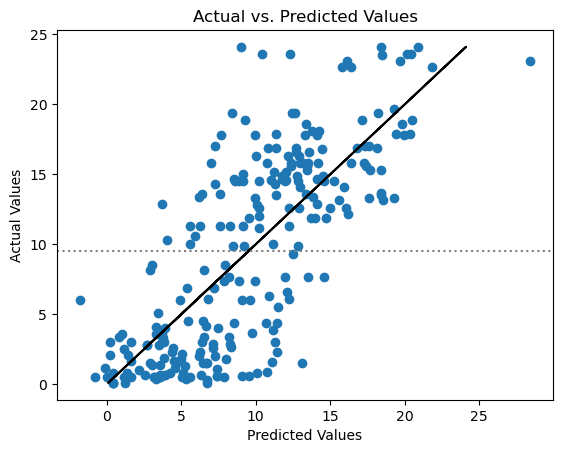

In [33]:
plt.title('Actual vs. Predicted Values')
plt.scatter(pred_lr1, y_train, label='linear regression')
# plt.scatter(pred_pr, y_train, label='ploynominal 2 deg', alpha=.8)
# plt.scatter(pred_glm, y_train, label='glm', alpha=.8)
plt.plot(y_train, y_train, label='_nolegend_', color='black')

plt.axhline(baseline, ls=':', color='grey')
# plt.annotate('Baseline', (0.2, 400_000))
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

plt.show()

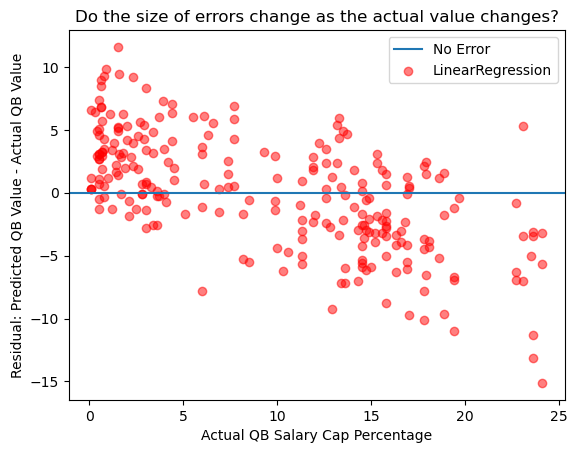

In [35]:
plt.axhline(label='No Error')

plt.scatter(y_train, pred_lr1 - y_train, alpha=.5, color='red', label='LinearRegression')
# plt.scatter(y_train, pred_glm - y_train, alpha=.5, color='gold', label='TweediRegressor')
# plt.scatter(y_train, pred_pr - y_train, alpha=.5, color='green', label='Polynomial 2deg')

plt.legend()
plt.title('Do the size of errors change as the actual value changes?')
plt.xlabel('Actual QB Salary Cap Percentage')
plt.ylabel('Residual: Predicted QB Value - Actual QB Value')

plt.show()

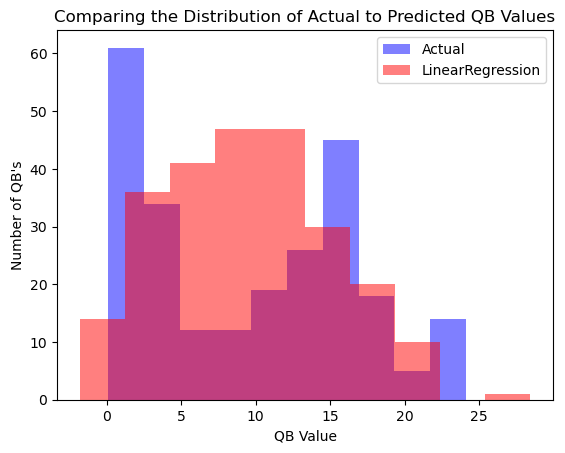

In [36]:
plt.hist(y_train, color='blue', alpha=.5, label='Actual')
plt.hist(pred_lr1, color='red', alpha=.5, label='LinearRegression')
# plt.hist(pred_glm, color='gold', alpha=.5, label='TweedieRegressor')
# plt.hist(pred_pr, color='green', alpha=.5, label='Polynomial 2Deg')

plt.xlabel("QB Value")
plt.ylabel("Number of QB's")
plt.title("Comparing the Distribution of Actual to Predicted QB Values")
plt.legend()
plt.show()

## Data dictionary

year | Year that specific row of stats were collected | integer  
games_played | The amount of games played in a specific season | float  
comp | Completion- Completed pass attempt | float  
att | Attempts- Number of passes made or attempted by the QB | float  
comp_pct | Completion Percentage- Percentage of completed passes vs. pass attempts | percentage, float  
yds | Yards- Total number of passing yards in that specific season | float  
avg_yds_per_att | Average Yards Per Attempt- Average yards gained per pass attempt | percentage, float  
td | Touchdown- highest scoring play | float  
int | Interception- Passing turnover, negative stat for QB's | float  
pass_rating | Passer Rating- one way to evaluate a QB's play performance. Scale from 0 - 158.3 higher the score the better | float  
rush_att | Rushing Attempts- How many times a QB ran the ball instead of passing | float  
rush_yds | Rushing Yards- Amount of yards gain from running the ball | float  
rush_avg | Rushing Average- Average yards gain from each run attempt | percentage, float  
rush_td | Rushing Touchdowns- The amount of touchdowns gained from running the ball | float  
year_signed | The year a QB signed a new contract | integer  
percent_of_cap (target variable) | The amount of cap space allocated to the player | percentage, float  
age | How old the QB is that specific season | integer  
td_perc | Touchdown Percentage- Percentage of touchdowns gained from passing attempts | percentage, float  
int_perc | Interception Percentage- Percentage of interceptions gained from passing attempts | percentage, float  
fir_dn_throws | First Down Throws- Amount of first downs a QB passes for. First down gain is a good stat for QB | integer  
lng_comp | Longest completion- longest completed pass play | integer  
yds_per_comp | Yards per completed pass- Average number of yards gained per completed pass | percentage, float  
yd_per_gm | Yards per Game- Average yards from pass completions per game | percentage, float  
QBR | Quarterback Rating- One way to evaluate a QB's play performance. Scale from 0 - 100 higher the score the better | float  
Sk | Sack- Number of times a QB was tackled for negative yards | integer  
4QC | Fourth Quarter Comeback- The QB's team was losing but the QB took the lead or tied the game in the fourth quarter | float  
GWD | Game winning drive- The QB's team was tied or losing but the QB took the lead to end the game | float  
win | Amount of wins the QB and their team gained | integer  
loss | Amount of losses the QB and their team gained | integer  
wild_card | First round of the playoffs. 1 = QB played that round 0 = QB did not play that round | float  
div_rnd | Second round of the playoffs. 1 = QB played that round 0 = QB did not play that round | float  
conf_rnd | Third round of the playoffs. 1 = QB played that round 0 = QB did not play that round | float  
superbowl | Final round of the playoffs. 1 = QB played that round 0 = QB did not play that round | float  
superbowl_win | 1 = QB won the superbowl 0 = QB did not win the superbowl | float  
win_perc | Percentage of games that the QB won in a specific season | percentage, float  
loss_perc | Percentage of games that the QB lost in a specific season |percentage, float  
td_per_game | The average number of touchdowns a QB passed for in games played | percentage, float  
sk_per_game | The average number of sacks on a QB per in games played | percentage, float  

#### Old definitions

tt | Time to throw: Average amount of time elapsed from the time of snap to throw on every pass attempt for a passer (sacks excluded) | float
cay | Completed air yards: Average total distance in yards of all passes that were completed in the season | float
iay | Intended air yards: Average total distance in yards of all passes | float
ayd | Air yards differential: Difference between completed and intended air yards | float
agg | Aggressiveness (in percent): Percentage of attempts where the ball was thrown to a receiver where there was a defender within one yard distance | percentage, float
lcad | Longest completed air distance: Distance in yards of longest completed throw that season | float
ayts | Air yards to the sticks: Average distance in yards ahead or behind the first down marker for all attempted passes | float
att | Passing attempts: The number of times that the quarterback threw the ball that season | integer
yds | Yards: Total number of yards that the quarterback threw that season | integer
td | Touchdowns: Number of touchdowns that quarterback threw | integer
int | Intercepts: Number of times that the quarterback's throw was intercepted by the opposing team | integer
rate | The given rating that a player is given by the NFL | float
comp | Completion probability: Probability of a pass completion (actual) | percentage, float
xcomp | Expected completion percentage: Probability of a pass completion (expected) | percentage, float
comp_diff | A quarterback's actual completion percentage compared to their expected | percentage, float


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             410 non-null    object 
 1   team             410 non-null    object 
 2   year             410 non-null    int64  
 3   games_played     410 non-null    float64
 4   comp             410 non-null    float64
 5   att              410 non-null    float64
 6   comp_pct         410 non-null    float64
 7   yds              410 non-null    float64
 8   avg_yds_per_att  410 non-null    float64
 9   td               410 non-null    float64
 10  int              410 non-null    float64
 11  pass_rating      410 non-null    float64
 12  rush_att         410 non-null    float64
 13  rush_yds         410 non-null    float64
 14  rush_avg         410 non-null    float64
 15  rush_td          410 non-null    float64
 16  full_name        410 non-null    object 
 17  year_signed     

In [ ]:
# round((df[df.year >= 2021].games_played / 17),2)

In [37]:
def show_target_var():
    plt.title('QB Salary Cap Distribution')
    sns.histplot(df.percent_of_cap, kde=True)
    plt.xlabel('Salary Cap Percent')
    plt.ylabel("Number of QB's")
    plt.show()

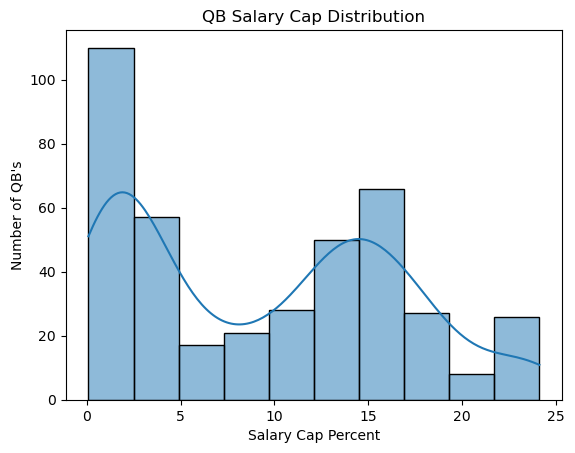

In [38]:
show_target_var()

In [39]:

from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
# rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [40]:
# rfe_feature

In [41]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')


,Var,Rank
15,td_perc,1
9,pass_rating,1
16,int_perc,2
6,avg_yds_per_att,3
19,yds_per_comp,4
2,comp,5
3,att,6
11,rush_yds,7
20,yds_per_gm,8
1,games_played,9


In [ ]:
# updated wild_card column. If a team made it to the second round via bye week, they made the first round so updated with 1

# master_df['wild_card'] = np.where(master_df.wild_card==0, master_df.div_rnd, master_df.wild_card)

In [ ]:
# master_df[master_df.div_rnd == 1]

In [ ]:
# master_df[master_df.year_signed == 2022][master_df[master_df.year_signed == 2022].year==2022]


In [ ]:
# dropping additional rows. These are QBs who signed a new contract in 2022 so the 2022 season stats go toward their new contract

# master_df = master_df.drop([167,271,346,412,350,360,189,111,139,72,84,444,161,362,363,364])

In [ ]:
# write over final csv with updated information

# master_df.to_csv('last_csv.csv', index=False)

$H_0$: Mean of percent of cap of super bowl winners <= Mean of percent of cap of non super bowl winners  
$H_a$: Mean of percent of cap of super bowl winners > Mean of percent of cap of non super bowl winners

<AxesSubplot:>

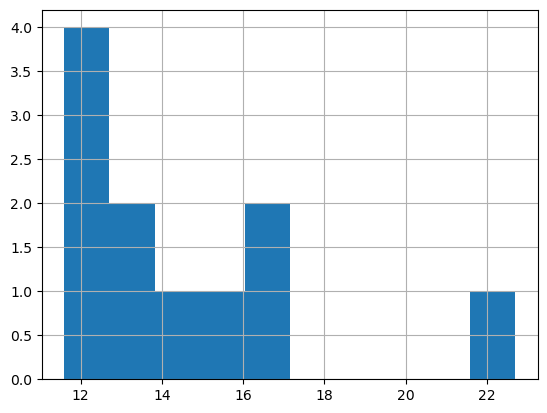

In [44]:
superbowl_sample = df[df.superbowl_win == 1].percent_of_cap
superbowl_sample.hist()

<AxesSubplot:>

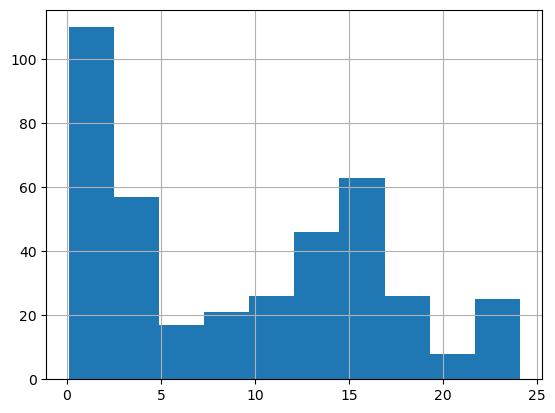

In [45]:
no_superbowl_sample = df[df.superbowl_win == 0].percent_of_cap

no_superbowl_sample.hist()

<AxesSubplot:xlabel='superbowl_win', ylabel='percent_of_cap'>

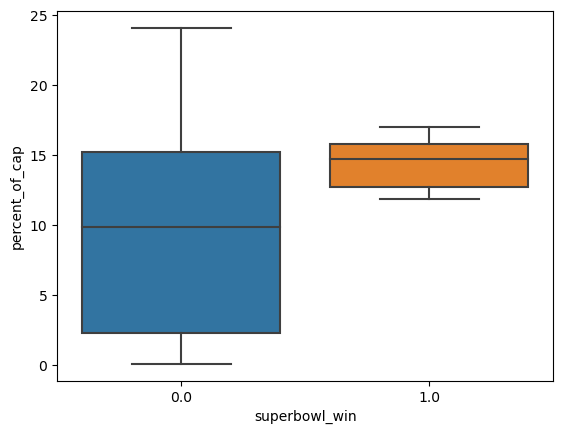

In [65]:
sns.boxplot(data = train, x='superbowl_win', y='percent_of_cap')

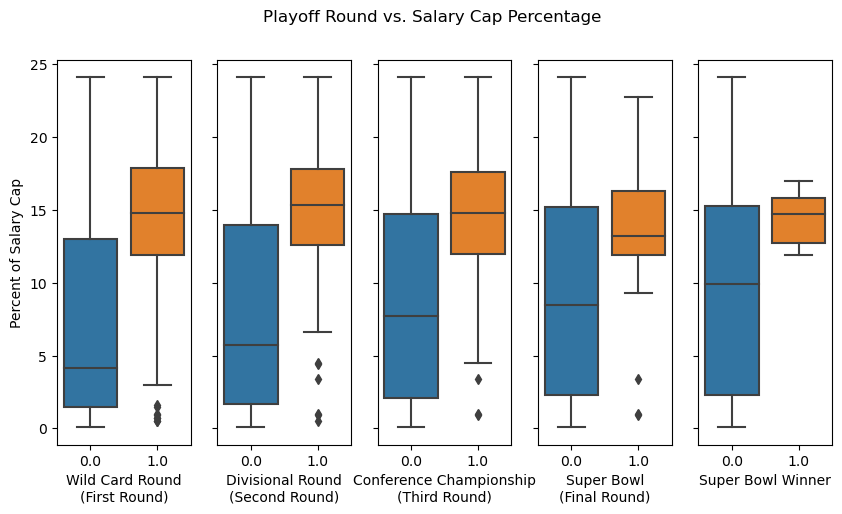

In [128]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5), sharey=True)

# Flatten the axes array
axes = axes.flatten()

# Set the super title
plt.suptitle("Playoff Round vs. Salary Cap Percentage")

# Plot on the first subplot
sns.boxplot(data = train, x='superbowl_win', y='percent_of_cap', ax=axes[4])
# axes[4].set_title("Winner")
axes[4].set_xlabel('Super Bowl Winner')
axes[4].set_ylabel('')  # Remove y-axis label

# Plot on the second subplot
sns.boxplot(data = train, x='superbowl', y='percent_of_cap', ax=axes[3])
# axes[3].set_title("Final Round")
axes[3].set_xlabel('Super Bowl\n(Final Round)')
axes[3].set_ylabel('')  # Remove y-axis label

# Plot on the Third subplot
sns.boxplot(data = train, x='conf_rnd', y='percent_of_cap', ax=axes[2])
# axes[2].set_title("Third Round")
axes[2].set_xlabel('Conference Championship\n(Third Round)')
axes[2].set_ylabel('')  # Remove y-axis label

# Plot on the fourth subplot
sns.boxplot(data = train, x='div_rnd', y='percent_of_cap', ax=axes[1])
# axes[1].set_title("Second Round")
axes[1].set_xlabel('Divisional Round\n(Second Round)')
axes[1].set_ylabel('')  # Remove y-axis label

# Plot on the fourth subplot
sns.boxplot(data = train, x='wild_card', y='percent_of_cap', ax=axes[0])
# axes[0].set_title("First Round")
axes[0].set_xlabel('Wild Card Round\n(First Round)')
axes[0].set_ylabel('Percent of Salary Cap')  # Remove y-axis label

# Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

Text(0.5, 1.0, 'Super Bowl Appearance vs. Salary Cap Percentage')

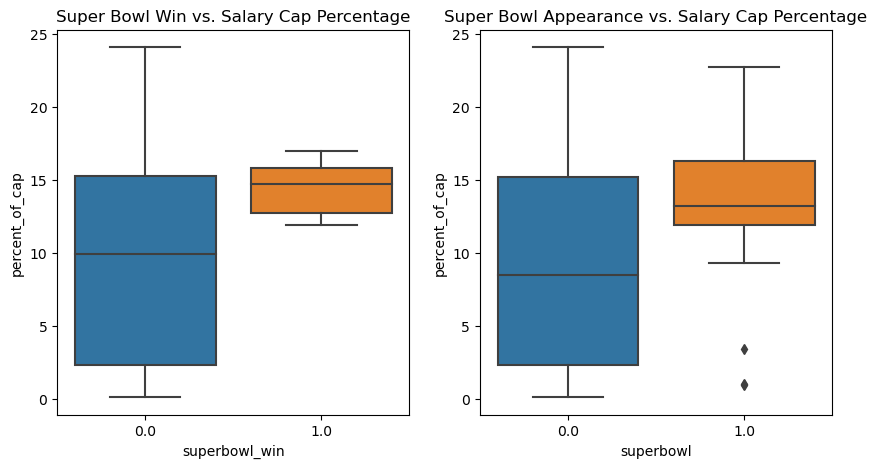

In [67]:
# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot on the first subplot
sns.boxplot(data = train, x='superbowl_win', y='percent_of_cap', ax=axes[0])
axes[0].set_title("Super Bowl Win vs. Salary Cap Percentage")

# Plot on the second subplot
sns.boxplot(data = train, x='superbowl', y='percent_of_cap', ax=axes[1])
axes[1].set_title("Super Bowl Appearance vs. Salary Cap Percentage")

In [46]:
alpha = .05

In [47]:
print(superbowl_sample.var())
print(no_superbowl_sample.var())

10.533636363636365
52.05977380637514


In [48]:
t, p = stats.ttest_ind(superbowl_sample, no_superbowl_sample, equal_var=False)
t, p / 2

(5.199061661736725, 8.775542373049033e-05)

In [51]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)

is p/2 < alpha?  True
is t > 0?  True


In [54]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We reject $H_{0}$


The mean percent of salary cap for super bowl winning QB's is greater than those who have not won a super bowl. QB's with super bowl wins get paid more money. 

In [57]:
def playoff_stats_test(df, var1, target):
    '''
    
    '''
    alpha = 0.05
    winner_sample = df[df[var1] == 1][target]
    loser_sample = df[df[var1] == 0][target]
    t, p = stats.ttest_ind(winner_sample, loser_sample, equal_var=False)
    
    if p / 2 > alpha:
        print("We fail to reject $H_{0}$")
    elif t < 0:
        print("We fail to reject $H_{0}$")
    else:
        print("We reject $H_{0}$")

In [64]:
playoff_stats_test(train, 'conf_rnd', 'percent_of_cap')


We reject $H_{0}$


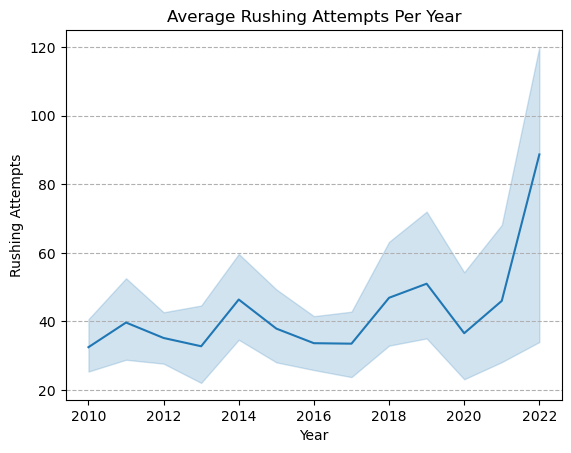

In [97]:
plt.title("Average Rushing Attempts Per Year")
sns.lineplot(data=train, x='year', y='rush_att')
plt.xlabel("Year")
plt.ylabel('Rushing Attempts')
# Add row grid lines
plt.grid(axis='y', linestyle='--')
plt.show()

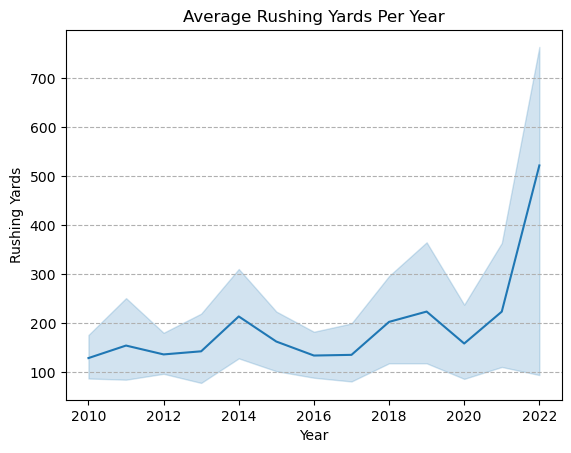

In [99]:
plt.title("Average Rushing Yards Per Year")
sns.lineplot(data=train, x='year', y='rush_yds')
plt.xlabel("Year")
plt.ylabel('Rushing Yards')
# Add row grid lines
plt.grid(axis='y', linestyle='--')
plt.show()

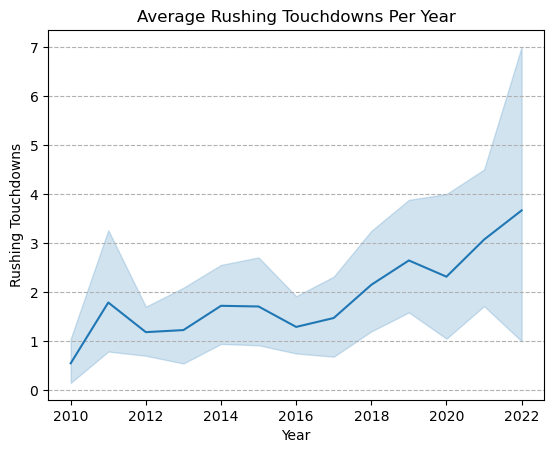

In [100]:
plt.title("Average Rushing Touchdowns Per Year")
sns.lineplot(data=train, x='year', y='rush_td')
plt.xlabel("Year")
plt.ylabel('Rushing Touchdowns')
# Add row grid lines
plt.grid(axis='y', linestyle='--')
plt.show()

In [84]:
train.rush_att.mean()

39.329268292682926

In [87]:
train[train.year == 2020].rush_att.sum()

695.0

In [88]:
df.head(7)

,name,team,year,games_played,comp,att,comp_pct,yds,avg_yds_per_att,td,int,pass_rating,rush_att,rush_yds,rush_avg,rush_td,full_name,year_signed,percent_of_cap,Player,Age,td_perc,int_perc,fir_dn_throws,lng_comp,yds_per_comp,yds_per_gm,QBR,Sk,4QC,GWD,win,loss,wild_card,div_rnd,conf_rnd,superbowl,superbowl_win,win_perc,loss_perc,td_per_game,sk_per_game
0,Blaine Gabbert,JAX,2011,15.0,210.0,413.0,50.8,2214.0,5.4,12.0,11.0,65.38,48.0,98.0,2.0,0.0,Blaine Gabbert,2011,1.4,Blaine Gabbert,22,2.9,2.7,111,74,10.5,147.6,22.2,40,0.0,0.0,4,10,0.0,0.0,0.0,0.0,0.0,0.27,0.67,0.80,2.67
1,Blaine Gabbert,JAX,2012,10.0,162.0,278.0,58.3,1662.0,6.0,9.0,6.0,77.35,18.0,56.0,3.1,0.0,Blaine Gabbert,2015,1.4,Blaine Gabbert,23,3.2,2.2,72,80,10.3,166.2,36.1,22,1.0,1.0,1,9,0.0,0.0,0.0,0.0,0.0,0.10,0.90,0.90,2.20
2,Blaine Gabbert,SF,2015,8.0,178.0,282.0,63.1,2031.0,7.2,10.0,7.0,86.17,32.0,185.0,5.8,1.0,Blaine Gabbert,2015,0.5,Blaine Gabbert,26,3.5,2.5,85,71,11.4,253.9,37.6,25,2.0,2.0,3,5,0.0,0.0,0.0,0.0,0.0,0.38,0.62,1.25,3.12
3,Blaine Gabbert,SF,2016,6.0,91.0,160.0,56.9,925.0,5.8,5.0,6.0,68.36,40.0,173.0,4.3,2.0,Blaine Gabbert,2017,0.5,Blaine Gabbert,27,3.1,3.8,50,75,10.2,154.2,54.1,11,0.0,0.0,1,4,0.0,0.0,0.0,0.0,0.0,0.17,0.67,0.83,1.83
4,Blaine Gabbert,ARI,2017,5.0,95.0,171.0,55.6,1086.0,6.4,6.0,6.0,71.92,22.0,82.0,3.7,0.0,Blaine Gabbert,2017,0.5,Blaine Gabbert,28,3.5,3.5,55,52,11.4,217.2,34.0,23,2.0,2.0,2,3,0.0,0.0,0.0,0.0,0.0,0.40,0.60,1.20,4.60
5,Michael Vick,PHI,2010,12.0,233.0,372.0,62.6,3018.0,8.1,21.0,6.0,100.18,100.0,676.0,6.8,9.0,Michael Vick,2011,13.3,Michael Vick,30,5.6,1.6,119,91,13.0,251.5,65.0,34,4.0,3.0,8,3,1.0,0.0,0.0,0.0,0.0,0.67,0.25,1.75,2.83
6,Michael Vick,PHI,2011,13.0,253.0,423.0,59.8,3303.0,7.8,18.0,14.0,84.86,74.0,590.0,8.0,1.0,Michael Vick,2011,6.1,Michael Vick,31,4.3,3.3,154,73,13.1,254.1,60.9,23,0.0,0.0,7,6,0.0,0.0,0.0,0.0,0.0,0.54,0.46,1.38,1.77


In [110]:
train.percent_of_cap.mean()

9.553252032520327